## <font color=darkcyan> Markov chain and Markov chain Monte Carlo methods</font>
$
\newcommand{\PP}{\mathbb P}
\newcommand{\PE}{\mathbb E}
\newcommand{\Xset}{\mathsf{X}}
\newcommand{\nset}{\mathbb{N}}
\newcommand{\invcdf}[1]{F_{#1}^{\leftarrow}}
\newcommand{\rmd}{\mathrm{d}}
\newcommand{\rme}{\mathrm{e}}
$

In [1]:
import matplotlib.pyplot as plt
import numpy.random as npr
from math import pi

# package which differentiates standard Python and Numpy code
import autograd.numpy as np   ## Attention ce n'est pas numpy std qu'on utilise ici
from autograd import grad

# to get progress bars
from tqdm import tqdm

#### <font color=darkorange> The invariant measure of a Markov chain </font>



#### Question 1



Consider a Gaussian AR($1$) process, $X_t= \mu + \phi X_{t-1} + \sigma Z_t$, where $(Z_t)_{t \in \nset}$ is an iid sequence of standard Gaussian random variables, independent of $X_0$. Assume that $|\phi| < 1$. Show that the Gaussian distribution with mean $\mu/(1-\phi)$ and variance $\sigma^2/(1-\phi^2)$ is a stationary distribution of the Markov chain.



Write $P(x,y) \propto \exp(-(y-\mu-\phi x)^2/(2\sigma^2)) $ the density of the AR(1) kernel. Then, we can compute $\pi P$ where $\pi$ is the Gaussian probability density function with mean $\tilde\mu$ and variance $\tilde\sigma^2$. For all $y$,
$$
\pi P(y) \propto \int  \exp(-(x-\tilde \mu)^2/(2\tilde\sigma^2))\exp(-(y-\mu-\phi x)^2/(2\sigma^2))\mathrm{d} x\,.
$$
This integral can be computed explicitly and $\pi P$ is a Gaussian probability density function. It is then enough to solve the equation $\pi P = \pi$.

An alternative is to note that if $X_0$ is Gaussian with mean $\mu_0$ and variance $\sigma^2_0$, then $X_1$ is Gaussian with mean $\phi\mu_0 + \mu$ and variance $\sigma^2 + \phi^2\sigma_0^2$ as $X_0$ and $Z_1$ are independent. The distribution of $X_0$ is a statitionary distribution if and only if $\mu_0 = \phi\mu_0 + \mu$ and $\sigma_0^2 = \sigma^2 + \phi^2\sigma_0^2$.

#### Question 2

Illustrate this property with an histogram of the values taken by a single trajectory of the Markov chain. 

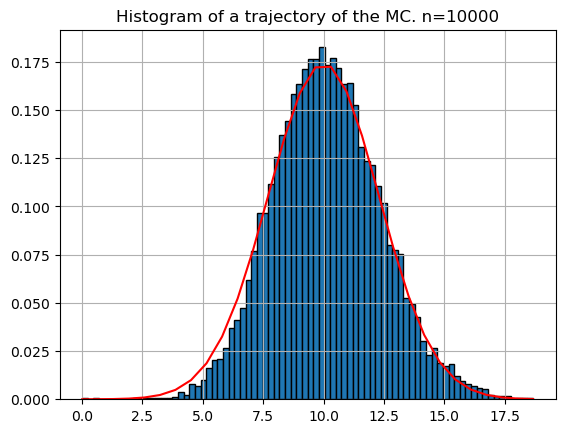

In [2]:
p,mu,phi,sig=10000,1,0.9,1
mc=npr.rand(1)*np.ones(p)

f=lambda x,m,sq: np.exp(-(x-m)**2/(2*sq))/np.sqrt(2*pi*sq)
mc[0]=0

for i in range(p-1):
    mc[i+1]=mu+phi*mc[i]+sig*npr.randn()

x=np.linspace(min(mc),max(mc),30)

fig, ax = plt.subplots()
ax.hist(mc,bins=80,density=True,edgecolor="black")
ax.plot(x,f(x,mu/(1-phi),sig**2/(1-phi**2)),color="red")
ax.grid(True)
plt.title(f"Histogram of a trajectory of the MC. n={p}")
plt.show()

#### <font color=darkorange> Symmetric Random Walk Metropolis Hasting algorithm </font>

We now consider a target distribution which is the mixture of two Gaussian distributions, one centered at $a>0$ and the other one centered at $-a$. For all $x\in\mathbb{R}$, 
$$
\pi(x)=\frac{1}{2}\left(\phi(x-a)+\phi(x+a)\right)=\frac{1}{2} \frac{\rme^{-(x-a)^2/2}}{\sqrt{2\pi}}+\frac{1}{2} \frac{\rme^{-(x+a)^2/2}}{\sqrt{2\pi}}\,,
$$
where $\phi$ is the density of the centered standard normal distribution. 

To target this distribution, we sample according to a Symmetric Random Walk Metropolis Hasting algorithm. Let $X_0$ be sampled with an arbitrary distribution. Then, for $k\geq 0$, when the chain is at the state $X_k$, we propose a candidate $Y_{k+1}$ according to $Y_{k+1}=X_k+ \sigma Z_k$ where $Z_k\sim {\mathcal N}(0,1)$ and then we accept $X_{k+1}=Y_{k+1}$ with probability $\alpha(X_k,Y_{k+1})$, where $\alpha(x,y)=\frac{\pi(y)}{\pi(x)} \wedge 1$. Otherwise, we set  $X_{k+1}=X_{k}$. 

#### Question 3

- Write the Symmetric Random Walk MH loop with target distribution $\pi$.
- Display the trajectory of the Markov chain.
- Display the histogram of the Markov chain as long as the target density.
- Compare empirically several choices of $a$ and $\sigma^2$.

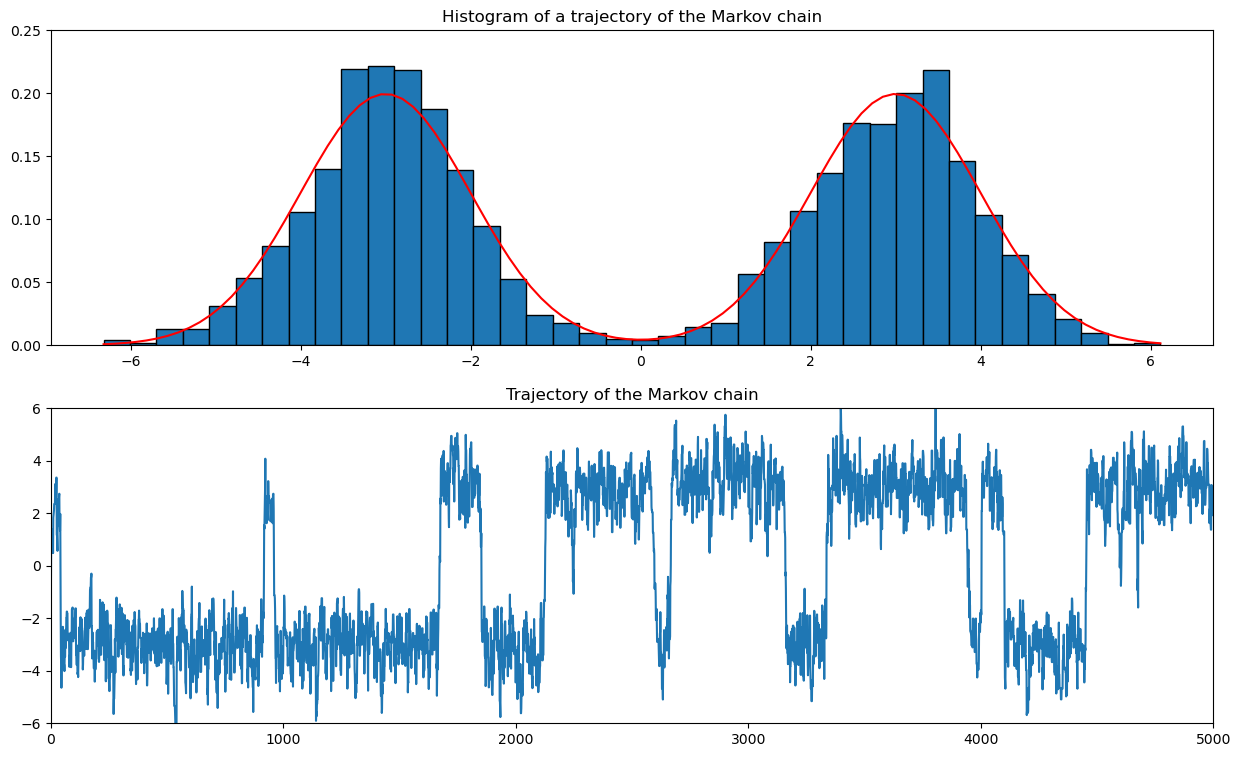

In [12]:
from IPython.display import HTML
from matplotlib import animation, rc

p = 5000
a = 3

mc = npr.randn()*np.ones(p)
target_dist = lambda x,a: (np.exp(-(x-a)**2/2)+np.exp(-(x+a)**2/2))/np.sqrt(8*pi)

samples = []
for i in range(p-1):
    v = npr.randn()
    alpha = target_dist(mc[i]+v,a)/target_dist(mc[i],a)
    mc[i+1] = mc[i]
    if (npr.rand()<alpha):
        mc[i+1] += v

s = np.cumsum(mc)/np.arange(1,p+1)
x = np.linspace(min(mc),max(mc),100)

fig, ax = plt.subplots(2,1, figsize=(15,9))
ax[0].cla()
ax[0].set_ylim(0, 0.25)
ax[0].hist(mc,bins = 40, density = True, edgecolor = "black")
ax[0].plot(x,target_dist(x,a),color="red")
ax[0].set_title("Histogram of a trajectory of the Markov chain")
ax[1].cla()
ax[1].set_xlim(0,p)
ax[1].set_ylim(-6,6)
ax[1].plot(mc)
ax[1].set_title("Trajectory of the Markov chain");

In [ ]:
def multi_gauss_logpdf(mu, sigma):
    """
    Inputs
    ----------
    mu: mean of the Gaussian distribution
    sigma: covariance matrix of the Gaussian distribution
    
    Outputs
    -------
    logp: loglikelihood
    """

    def logp(x): 
        """
        Inputs
        ----------
        x: array of size nxd
    
        Outputs
        -------
        Gaussian logdensity evaluated on all n points
        """
        d = mu.shape[0]
        cst = d * np.log(2 * np.pi)
        det = np.log(np.linalg.det(sigma))
        diff = x-mu
        quad_term = np.einsum('...i,ij,...j', diff, np.linalg.inv(sigma), diff)
        
        return -0.5 *(cst +  det + quad_term) 
    
    return logp

def mixture_logpdf(log_probs, weights):
    """
    Inputs
    ----------
    log_probs: loglikelihood of each term
    weights: weights of the components of the mixture
    
    Outputs
    -------
    logp: loglikelihood of the mixture
    """
    
    def logp(x):
        log_marginals = np.array([log_probs[j](x) for j in range(len(log_probs))])
        return np.log(np.einsum('i,i...', weights, np.exp(log_marginals)))
    
    return logp

We write a solution for any target density when we know the opposite of the logdensity to sample from

In [ ]:
def MH_monte_carlo(n_samples, log_prob, initial_state, step_size = 0.1):
    """
    Inputs
    ----------
    n_samples: number of samples to return
    log_prob: loglikelihood to sample from
    initial_state: initial sample
    step_size: standard deviation of the proposed moves
    
    Outputs
    -------
    samples: samples from the MCMC algorithm
    accepted: array of 0 and 1 to display which proposed moves have been accepted
    """
    initial_state = np.array(initial_state)
    
    samples  = [initial_state]
    accepted = []

    size = (n_samples,) + initial_state.shape[:1]
    
    # random variable to sample proposed moves
    epsilon = npr.normal(size = size)
    
    for noise in tqdm(epsilon):
        
        q_new = samples[-1] + step_size*noise
       
        # acceptance rate
        old_log_p = log_prob(samples[-1]) 
        new_log_p = log_prob(q_new) 
        
        if np.log(np.random.rand()) < new_log_p - old_log_p:
            samples.append(q_new)
            accepted.append(True)
        else:
            samples.append(np.copy(samples[-1]))
            accepted.append(False)

    return (np.array(samples[1:]),np.array(accepted),)

In [ ]:
mu1 = 2*np.ones(2)
cov1 = np.array([[1., 0.5],
                [0.5, 1.]])
mu2 = -mu1
cov2 = np.array([[1., -0.1],
                [-0.1, 1.]])

mu3 = np.array([-1.5, 2])
cov3 = 0.8 * np.eye(2)

log_p = mixture_logpdf([multi_gauss_logpdf(mu1, cov1), multi_gauss_logpdf(mu2, cov2), multi_gauss_logpdf(mu3, cov3)],[0.3,0.3,0.4])

In [ ]:
# Run HM algorithm with symmetric RW
n_samples = 20000
step_size = 0.2
samples_MH, accepted_MH = MH_monte_carlo(n_samples, log_p, np.random.randn(2), step_size)

In [ ]:
# True mixture density values
grid_lim = 6
nb_points = 100

xplot = np.linspace(-grid_lim, grid_lim, nb_points)
yplot = np.linspace(-grid_lim, grid_lim, nb_points)
Xplot, Yplot = np.meshgrid(xplot, yplot)

XY = np.dstack((Xplot,Yplot))

Zplot = np.exp(log_p(XY))

In [ ]:
# Display Markov chain vs true density
fig, ax = plt.subplots(figsize=(8,10))
ax.grid(True, color="white")
pcm = ax.pcolormesh(Xplot, Yplot, Zplot, cmap = 'Blues')
fig.colorbar(pcm,orientation='horizontal', label='True density values')
ax.plot(samples_MH[:,0], samples_MH[:,1], '.', color='orange', alpha = 0.1, label = 'RW Metropolis-Hastings samples')
plt.legend()

In [ ]:
# Display trajectories
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].plot(samples_MH[:,0], alpha = 0.5)
axs[0].set_title('1st coordinate')
axs[1].plot(samples_MH[:,1], alpha = 0.5, c='orange')
axs[1].set_title('2nd coordinate')
fig.suptitle("RW Metropolis-Hastings trajectories")

#### <font color=darkorange> Independent Metropolis Hasting algorithm </font>

We again consider a target distribution which is a mixture of two Gaussian distributions, one centered at $a>0$ and the other one centered at $-a$ 
$$
\pi(x)=\frac{1}{2}\left(\phi(x-a)+\phi(x+a)\right)=\frac{1}{2} \frac{\rme^{-(x-a)^2/2}}{\sqrt{2\pi}}+\frac{1}{2} \frac{\rme^{-(x+a)^2/2}}{\sqrt{2\pi}},
$$
where $\phi$ is the density of the centered standard normal distribution. 

To target this distribution, we sample according to a Metropolis Hasting algorithm with independent proposal.  Let $X_0$ be sampled with an arbitrary distribution. Then, for $k\geq 0$, when the chain is at the state $X_k$, we propose a candidate $Y_{k+1}$ according to $Y_{k+1}=Z_k$ where $Z_k\sim {\mathcal N}(\theta,\sigma^2)$ and then we accept $X_{k+1}=Y_{k+1}$ with probability $\alpha(X_k,Y_{k+1})$, where $\alpha(x,y)=\frac{\pi(y)q(x)}{\pi(x)q(y)} \wedge 1=\frac{\pi(y)/q(y)}{\pi(x)/q(x)} \wedge 1$ and $q$ is the density of the Gaussian distribution with mean $\theta$ and variance $\sigma^2$. Otherwise, we set $X_{k+1}=X_{k}$. 

#### Question 4

- Write the independent MH loop with target distribution $\pi$.
- Display the trajectory of the Markov chain.
- Display the histogram of the Markov chain as long as the target density.

In [ ]:
def MH_independent(n_samples, log_prob, initial_state, step_size = 0.1):
    """
    Inputs
    ----------
    n_samples: number of samples to return
    log_prob: loglikelihood to sample from
    initial_state: initial sample
    step_size: standard deviation of the proposed moves
    
    Outputs
    -------
    samples: samples from the MCMC algorithm
    accepted: array of 0 and 1 to display which proposed moves have been accepted
    """
    initial_state = np.array(initial_state)
    
    samples  = [initial_state]
    accepted = []

    size = (n_samples,) + initial_state.shape[:1]
    
    # random variable to sample proposed moves
    epsilon = npr.normal(size = size)
    
    for noise in tqdm(epsilon):
        
        q_new = step_size*noise
       
        # acceptance rate
        old_log_p = log_prob(samples[-1]) 
        new_log_p = log_prob(q_new) 
        
        if np.log(np.random.rand()) < (new_log_p-old_log_p) + 0.5*(np.dot(samples[-1],samples[-1]) - np.dot(q_new,q_new))/step_size**2:
            samples.append(q_new)
            accepted.append(True)
        else:
            samples.append(np.copy(samples[-1]))
            accepted.append(False)

    return (np.array(samples[1:]),np.array(accepted),)

In [ ]:
# Run HM algorithm with independent proposals
n_samples = 20000
step_size = 1
samples_ind, accepted_ind = MH_independent(n_samples, log_p, np.random.randn(2), step_size)

In [ ]:
# Display Markov chain vs true density
fig, ax = plt.subplots(figsize=(8,10))
ax.grid(True, color="white")
pcm = ax.pcolormesh(Xplot, Yplot, Zplot, cmap = 'Blues')
fig.colorbar(pcm,orientation='horizontal', label='True density values')
ax.plot(samples_ind[:,0], samples_ind[:,1], '.', color='orange', alpha = 0.1, label = 'RW Metropolis-Hastings samples')
plt.legend()

In [ ]:
# Display trajectories
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].plot(samples_ind[:,0], alpha = 0.5)
axs[0].set_title('1st coordinate')
axs[1].plot(samples_ind[:,1], alpha = 0.5, c='orange')
axs[1].set_title('2nd coordinate')
fig.suptitle("Independent Metropolis-Hastings trajectories")

#### <font color=darkorange> Metropolis Adjusted Langevin algorithm (MALA) </font>


``Objective target density:`` $\pi$.

At each iteration $k\geqslant 0$, generate $Z_{k+1} \sim X_k + \frac{\sigma}{2}\nabla\log\pi(X_k) + \sigma \varepsilon_{k+1}$.

Set $X_{k+1} = Z_{k+1}$ with probability $\alpha(X_k,Z_{k+1})$ and  $X_{k+1} = X_k$ with probability $1-\alpha(X_k,Z_{k+1})$, where 

$$
\alpha(x,y) = 1\wedge\frac{\pi(y)}{\pi(x)}\frac{q(y,x)}{q(x,y)}\,,
$$

where $y\mapsto q(x,y)$ is the Gaussian pdf with mean $x + \frac{\sigma}{2}\nabla\log\pi(x)$ and variance $\sigma^2 I_d$.

#### Question 5

- Write the Metropolis Adjusted Langevin algorithm loop with target distribution $\pi$.
- Display the trajectory of the Markov chain.
- Display the histogram of the Markov chain as long as the target density.
- Compare empirically several choices of $\sigma^2$.

In [ ]:
def MALA_monte_carlo(n_samples, log_prob, initial_state, step_size = 0.1):
    """
    Inputs
    ----------
    n_samples: number of samples to return
    log_prob: opposite of the loglikelihood to sample from
    initial_state: initial sample
    step_size: standard deviation of the proposed moves
    
    Outputs
    -------
    samples: samples from the MCMC algorithm
    accepted: array of 0 and 1 to display which proposed moves have been accepted
    """
    initial_state = np.array(initial_state)

    gradV = grad(log_prob)

    samples  = [initial_state]
    accepted = []

    size = (n_samples,) + initial_state.shape[:1]
    
    # random variable to sample proposed moves
    epsilon = npr.normal(size = size)
    
    for noise in tqdm(epsilon):
        
        grad_new = gradV(samples[-1])
        mean_new = samples[-1] - 0.5*step_size*grad_new
        
        q_new    = mean_new + step_size*noise
       
        grad_y   = gradV(q_new)
        mean_y   = q_new - 0.5*step_size*grad_y
        
        # acceptance rate
        old_log_p = -log_prob(samples[-1]) + 0.5*np.dot(q_new-mean_new,q_new-mean_new)/(step_size**2)
        new_log_p = -log_prob(q_new) + 0.5*np.dot(samples[-1]-mean_y,samples[-1]-mean_y)/(step_size**2)
        
        if np.log(np.random.rand()) < old_log_p - new_log_p:
            samples.append(q_new)
            accepted.append(True)
        else:
            samples.append(np.copy(samples[-1]))
            accepted.append(False)

    return (np.array(samples[1:]),np.array(accepted),)

In [ ]:
# Run Metropolis Adjusted Langevin algorithm
n_samples = 20000
step_size = 0.2
samples_Mala, accepted_Mala = MALA_monte_carlo(n_samples, log_p, np.random.randn(2), step_size)

In [ ]:
# Display Markov chain vs true density
fig, ax = plt.subplots(figsize=(8,10))
ax.grid(True, color="white")
pcm = ax.pcolormesh(Xplot, Yplot, Zplot, cmap = 'Blues')
fig.colorbar(pcm,orientation='horizontal', label='True density values')
ax.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='orange', alpha = 0.1, label = 'MALA samples')
plt.legend()

In [ ]:
# Display trajectories
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].plot(samples_Mala[:,0], alpha = 0.5)
axs[0].set_title('1st coordinate')
axs[1].plot(samples_Mala[:,1], alpha = 0.5, c='orange')
axs[1].set_title('2nd coordinate')
fig.suptitle("MALA trajectories")

#### Question 6
Compare all MH versions when the target $\pi$ is a mixture of Gaussian distributions.